## Project 1 

Part a) : Ordinary Least Square (OLS) on the Franke function

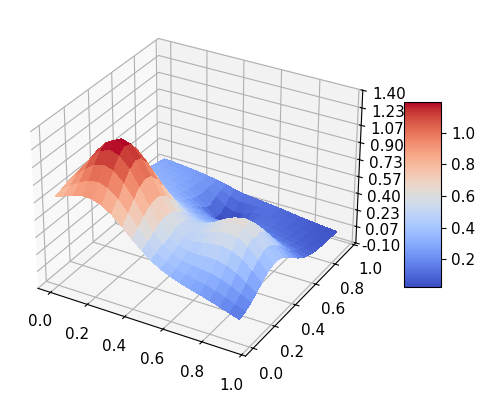

In [833]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
#Make data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y): #Defining the given franke function
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

#Plot the surface
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#setting the z axis
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


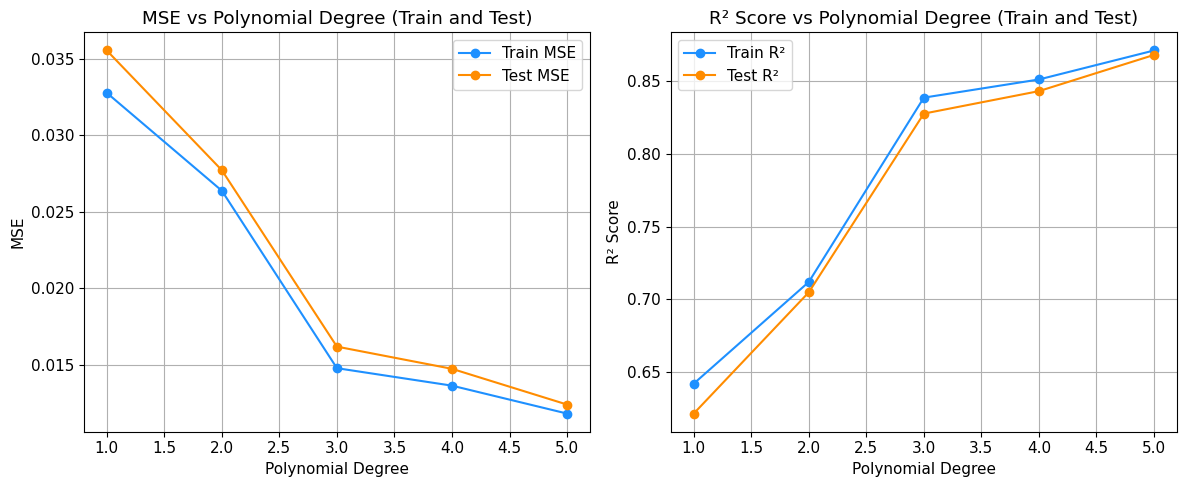

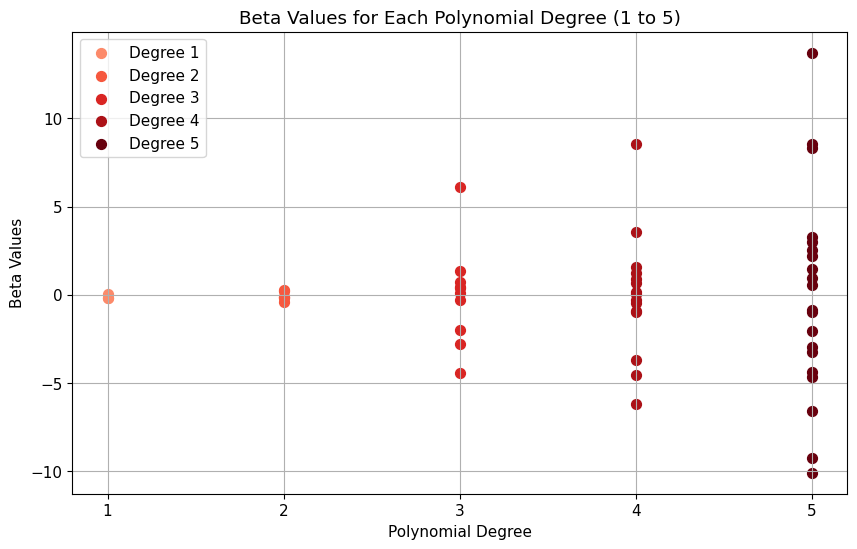

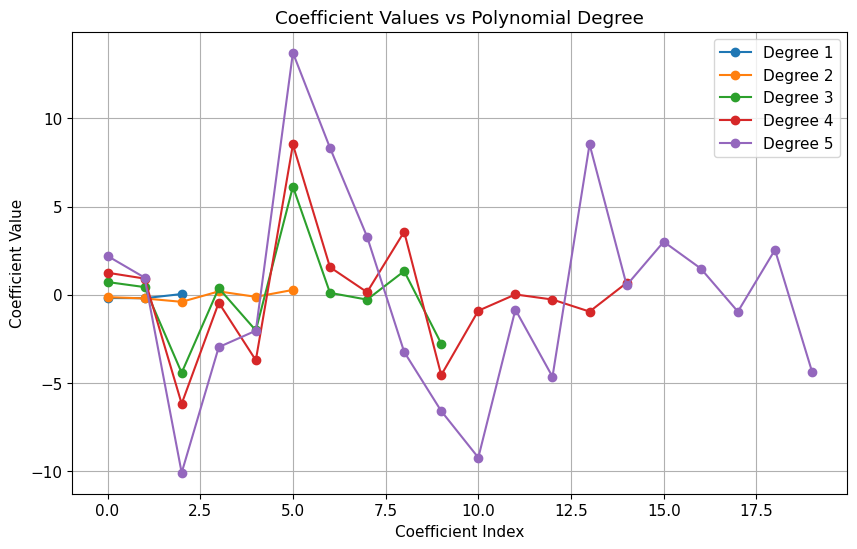

In [834]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#franke Function definition
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

#create design matrix with polynomial features
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
    
    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  #number of elements in beta
    X = np.ones((N, l))
    
    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)
    
    return X

np.random.seed(1040)

#generate data
degree = 5 #polynomial degree
N = 10000 #number of points
x = np.random.rand(N)
y = np.random.rand(N)
z = FrankeFunction(x, y)  + 0.1 * np.random.randn(N) #Franke with noise = 0.1, normally distributed

#create polynomial design matrix for degree 5
X = create_X(x, y, n=degree)
X = X[:, 1:]  #remove the intercept column

#Split into training and test data
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

#Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#centering the z values
z_train_mean = np.mean(z_train)
z_train_scaled = z_train - z_train_mean
z_test_scaled = z_test - z_train_mean

MSE_train_values = []
MSE_test_values = []
R2_train_values = []
R2_test_values = []
beta_values = []

for i in range(1, degree + 1):
    c = int((i + 2) * (i + 1) / 2) #number columns
    X_tilde_train = X_train_scaled[:, :c] #choosing colums for the degree
    X_tilde_test = X_test_scaled[:, :c] 
    
    beta = np.linalg.pinv(X_tilde_train.T @ X_tilde_train) @ X_tilde_train.T @ z_train_scaled 
    beta_values.append(beta)
    
    y_train_pred = X_tilde_train @ beta + z_train_mean
    y_test_pred = X_tilde_test @ beta + z_train_mean
    
    MSE_train_values.append(mean_squared_error(z_train, y_train_pred))
    MSE_test_values.append(mean_squared_error(z_test, y_test_pred))
    R2_train_values.append(r2_score(z_train, y_train_pred))
    R2_test_values.append(r2_score(z_test, y_test_pred))

degrees = np.arange(1, degree + 1)

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, MSE_train_values, marker='o', label='Train MSE', color='dodgerblue')
plt.plot(degrees, MSE_test_values, marker='o', label='Test MSE', color='darkorange')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(degrees, R2_train_values, marker='o', label='Train R²', color='dodgerblue')
plt.plot(degrees, R2_test_values, marker='o', label='Test R²', color='darkorange')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

reds = plt.cm.Reds(np.linspace(0.4, 1, 5)) 

#plotting betas
for i, beta in enumerate(beta_values[:5]):
    plt.scatter([i + 1] * len(beta), beta, marker='o', color=reds[i], label=f'Degree {i+1}', s=50)

plt.xticks(np.arange(1, 6))
plt.xlabel('Polynomial Degree')
plt.ylabel('Beta Values')
plt.title('Beta Values for Each Polynomial Degree (1 to 5)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot coefficients
plt.figure(figsize=(10, 6))
for i in range(len(beta_values)):
    plt.plot(beta_values[i], marker='o', label=f'Degree {i+1}')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Values vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

Part b): Adding Ridge regression for the Franke function

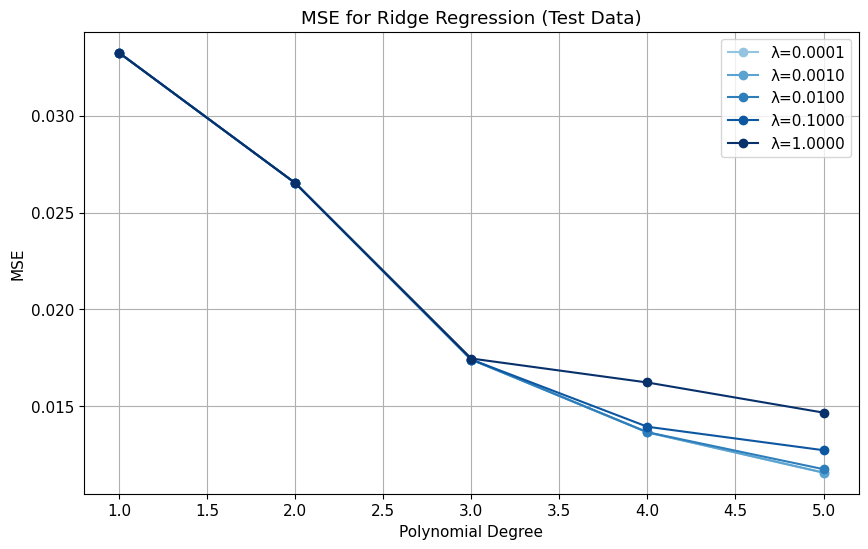

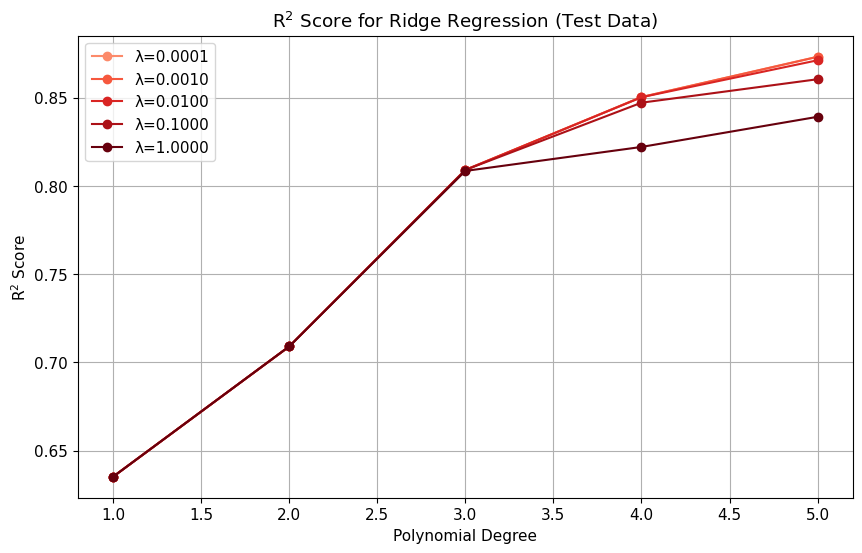

In [835]:
degrees = np.arange(1, 6)
lambdas = np.logspace(-4, 0, 5) #lambda vals from 0.0001 to 1

MSE_Ridge_train = np.zeros((len(degrees), len(lambdas)))
MSE_Ridge_test = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_train = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x, y, n=deg)
    X = X[:, 1:]  # remove the intercept

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

    #scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #center
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    #making identity matrix, p is number of columns in design matrix
    p = X_train_scaled.shape[1]
    I = np.eye(p)

    for j, lmb in enumerate(lambdas):
        #ridge regression
        Ridgebeta = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lmb * I) @ X_train_scaled.T @ z_train_scaled
        
        y_train_pred = X_train_scaled @ Ridgebeta + z_train_mean
        y_test_pred = X_test_scaled @ Ridgebeta + z_train_mean

        MSE_Ridge_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Ridge_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Ridge_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Ridge_test[i, j] = r2_score(z_test, y_test_pred)

#pretty colors
mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


Part c): Adding Lasso for the Franke function

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 7.382e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.380e+00, tolerance: 7.382e-02
  model = cd_fast.enet_coordinate_descent(


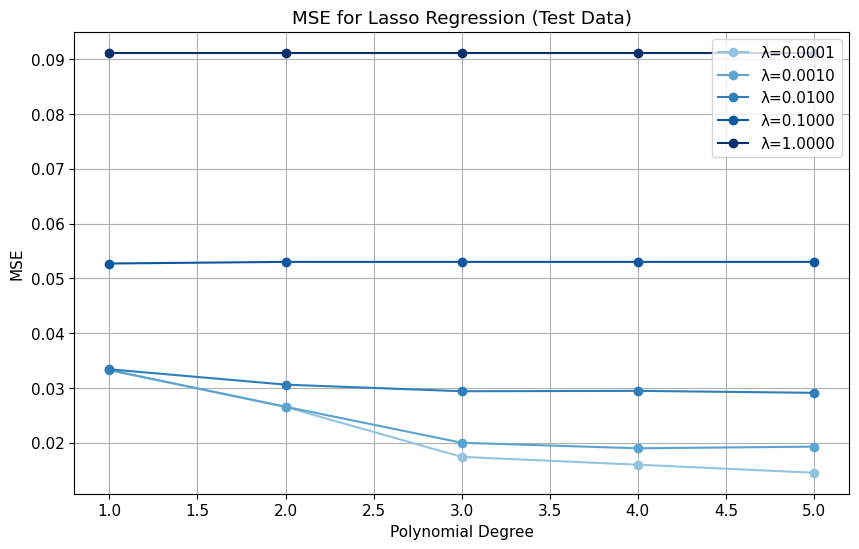

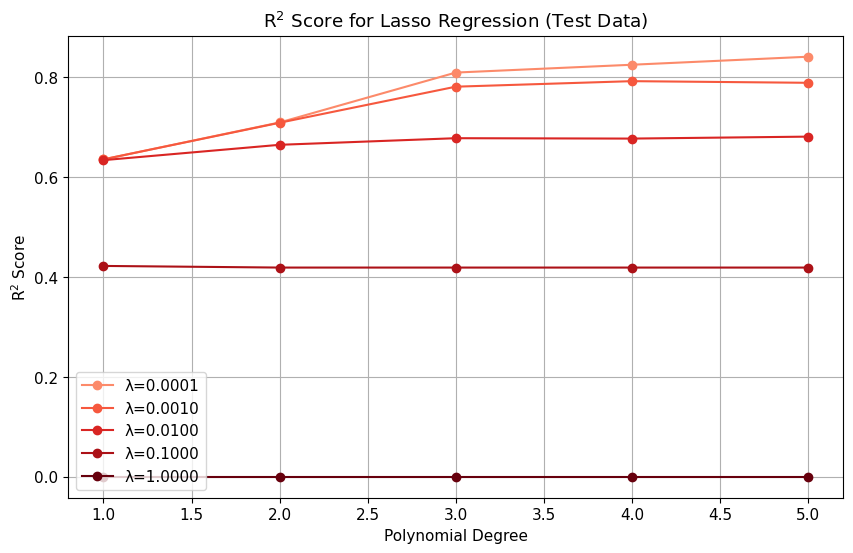

In [836]:
from sklearn.linear_model import Lasso 

MSE_Lasso_train = np.zeros((len(degrees), len(lambdas)))
MSE_Lasso_test = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_train = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x, y, n=deg)
    X = X[:, 1:]  #remove the intercept

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)
  
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    #lasso regression
    for j, lmb in enumerate(lambdas):

        lasso = Lasso(alpha=lmb, max_iter=10000) 
        lasso.fit(X_train_scaled, z_train_scaled)

        y_train_pred = lasso.predict(X_train_scaled) + z_train_mean
        y_test_pred = lasso.predict(X_test_scaled) + z_train_mean

        MSE_Lasso_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Lasso_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Lasso_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Lasso_test[i, j] = r2_score(z_test, y_test_pred)


#pretty colors
mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))
plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

Plottet OLS, Rigde and Lasso together:

In [837]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

#defining MSE
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2) / n

#defining R2
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - np.mean(y_data))**2)

#create and fit a ridge regression model, finding best lambda
model = Ridge()
gridsearch = GridSearchCV(estimator=model, param_grid={'alpha': lambdas}, scoring='neg_mean_squared_error', cv=5)
gridsearch.fit(X_train, z_train)

#create and fit a lasso regression model, finding best lambda
model2 = Lasso()
gridsearch2 = GridSearchCV(estimator=model2, param_grid={'alpha': lambdas}, scoring='neg_mean_squared_error', cv=5)
gridsearch2.fit(X_train,z_train)

ypredictRidge = gridsearch.predict(X_test)
ypredictLasso = gridsearch2.predict(X_test)

print(f"Best estimated lambda-value Ridge: {gridsearch.best_estimator_.alpha}")
print(f"MSE score: {MSE(z_test, ypredictRidge):.5f}")
print(f"R2 score: {R2(z_test, ypredictRidge):.5f}")
print(f"Best estimated lambda-value Lasso: {gridsearch2.best_estimator_.alpha}")

print(f"MSE score: {MSE(z_test, ypredictLasso):.5f}")
print(f"R2 score: {R2(z_test, ypredictLasso):.5f}")

Best estimated lambda-value Ridge: 0.0001
MSE score: 0.01157
R2 score: 0.87306
Best estimated lambda-value Lasso: 0.0001
MSE score: 0.01817
R2 score: 0.80069


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.827e+00, tolerance: 5.835e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.957e+00, tolerance: 5.933e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

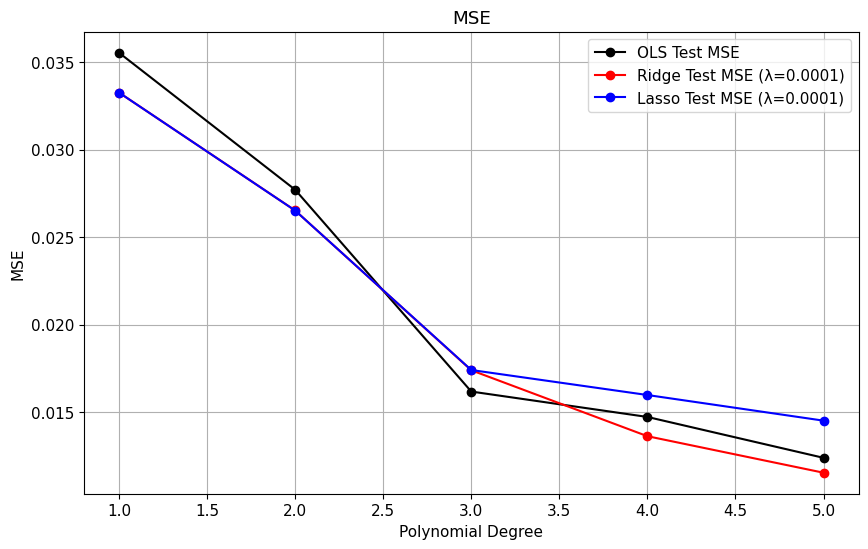

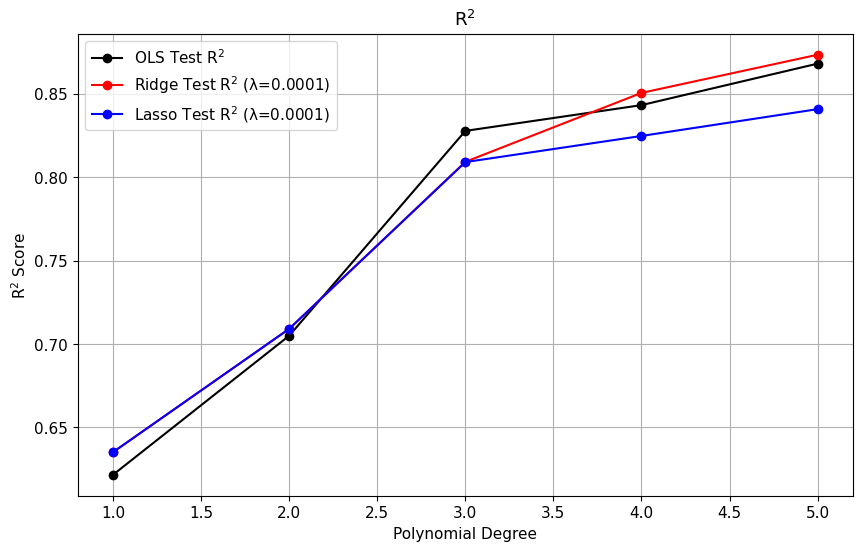

In [838]:
#using best lambda value
lambda_value = 0.0001

best_MSE_Ridge_test = MSE_Ridge_test[:, 0] 
best_MSE_Lasso_test = MSE_Lasso_test[:, 0]

best_R2_Ridge_test = R2_Ridge_test[:, 0]
best_R2_Lasso_test = R2_Lasso_test[:, 0]

plt.rcParams.update({'font.size': 11})

#plotting OLS, Ridge and Lasso together with best lambda

plt.figure(figsize=(10, 6))
plt.plot(degrees, MSE_test_values, marker='o', label='OLS Test MSE', color='black')
plt.plot(degrees, best_MSE_Ridge_test, marker='o', label='Ridge Test MSE (λ=0.0001)', color='red')
plt.plot(degrees, best_MSE_Lasso_test, marker='o', label='Lasso Test MSE (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(degrees, R2_test_values, marker='o', label='OLS Test R$^2$', color='black')
plt.plot(degrees, best_R2_Ridge_test, marker='o', label='Ridge Test R$^2$ (λ=0.0001)', color='red')
plt.plot(degrees, best_R2_Lasso_test, marker='o', label='Lasso Test R$^2$ (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$')
plt.legend()
plt.grid(True)
plt.show()


Part e): Bias-variance trade-off and resampling techniques

Degree 1: Error = 0.0339, Bias^2 = 0.0328, Variance = 0.0011
Degree 2: Error = 0.0321, Bias^2 = 0.0303, Variance = 0.0018
Degree 3: Error = 0.0184, Bias^2 = 0.0165, Variance = 0.0019
Degree 4: Error = 0.0148, Bias^2 = 0.0110, Variance = 0.0037
Degree 5: Error = 0.0228, Bias^2 = 0.0120, Variance = 0.0108


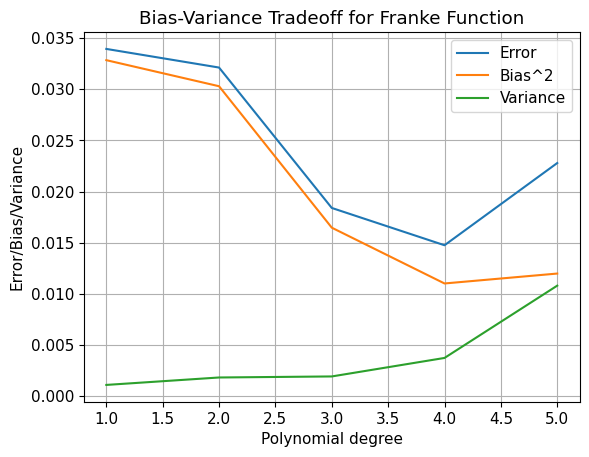

In [839]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

n = 100 #select fewer points because of computational efficiency
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y) + 0.1 * np.random.normal(0, 1, x.shape)

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

n_boostraps = 100 #number of bootstraps
maxdegree = 5 #degree 5

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.arange(1, maxdegree + 1)

z_test = z_test.reshape(-1, 1) #reshape to fit dimensions

for degree in range(1, maxdegree + 1):
    X_train_poly = create_X(x_train, y_train, degree)
    X_test_poly = create_X(x_test, y_test, degree)
    z_pred = np.empty((z_test.shape[0], n_boostraps))  #store bootstrap predictions

    #bootstrap resampling
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_poly, z_train)
        model = LinearRegression(fit_intercept=False)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test_poly).ravel()

    #calc error, bias, and variance
    error[degree-1] = np.mean(np.mean((z_test - z_pred) ** 2, axis=1))
    bias[degree-1] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
    variance[degree-1] = np.mean(np.var(z_pred, axis=1))

    print(f'Degree {degree}: Error = {error[degree-1]:.4f}, Bias^2 = {bias[degree-1]:.4f}, Variance = {variance[degree-1]:.4f}')

plt.rcParams.update({'font.size': 11})
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='Bias^2')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polynomial degree')
plt.ylabel('Error/Bias/Variance')
plt.legend()
plt.title('Bias-Variance Tradeoff for Franke Function')
plt.grid(True)
plt.show()


Part f): Cross-validation as resampling techniques, adding more complexity

/var/folders/sq/czqm3zt15lb2_07cs887bdnw0000gn/T/ipykernel_59830/3191556030.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


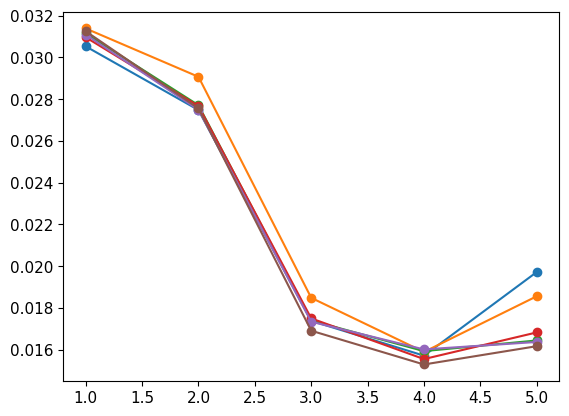

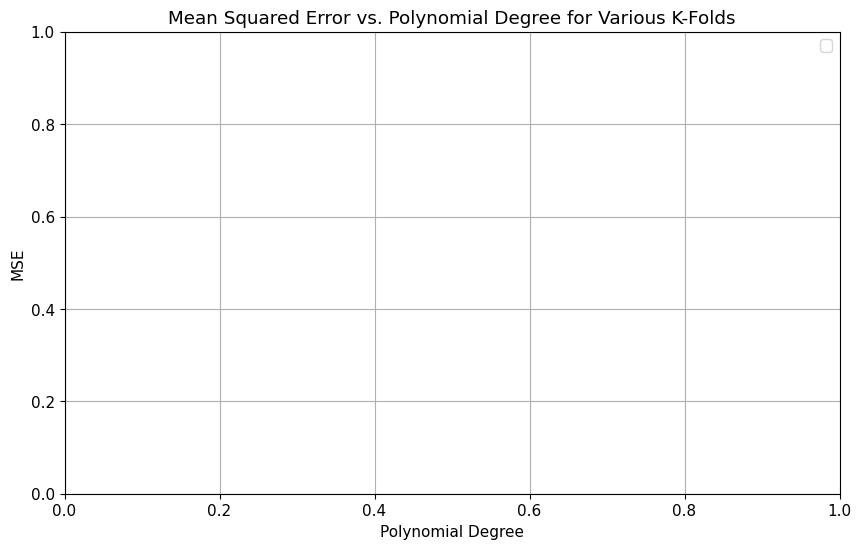

In [840]:
from sklearn.model_selection import KFold, cross_val_score

degree = 5
polynomial_degrees = np.arange(1, degree + 1)

for k in range(5, 11):
    #making an empty list to store MSE values
    estimated_mse = np.zeros(degree)
    
    #loop over degrees
    for polydegree in polynomial_degrees:
        X = create_X(x, y, polydegree) 
        OLS = LinearRegression(fit_intercept=False)
        
        kfold = KFold(n_splits=k, shuffle=True, random_state=1042)  #initialize kfold instance
        mse_scores = cross_val_score(OLS, X, z, scoring='neg_mean_squared_error', cv=kfold) #perform cross validation to estimate MSE
        
        #store the negative MSE for every fold
        estimated_mse[polydegree - 1] = -np.mean(mse_scores)  #average and negate MSE

    plt.plot(polynomial_degrees, estimated_mse, marker='o', label=f'{k}-Fold CV')

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 6))

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error vs. Polynomial Degree for Various K-Folds')
plt.legend()
plt.grid(True)
plt.show()

Part g): Analysis of real data

/var/folders/sq/czqm3zt15lb2_07cs887bdnw0000gn/T/ipykernel_59830/4199517106.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


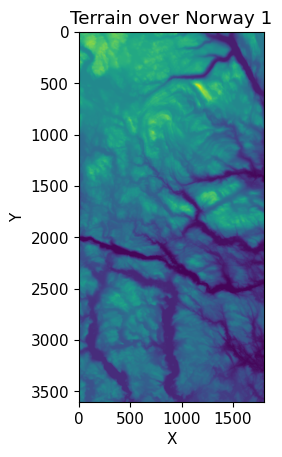

In [841]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(1040)
plt.rcParams.update({'font.size': 11})
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

/var/folders/sq/czqm3zt15lb2_07cs887bdnw0000gn/T/ipykernel_59830/1437477275.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


Dimensions of terrain data: (3601, 1801)


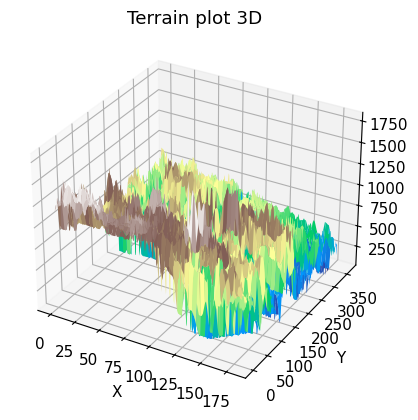

In [842]:
print("Dimensions of terrain data:", terrain1.shape)

from imageio import imread

terrain1 = imread('SRTM_data_Norway_1.tif')
terrain1 = terrain1[::10,::10] #sample the data by selecting every 10th point

fig = plt.figure()
ax = plt.axes(projection='3d')

#make data
x = np.arange(terrain1.shape[1]) #width
y = np.arange(terrain1.shape[0]) #height

X, Y = np.meshgrid(x, y)

#flatten
x_flat = X.ravel() 
y_flat = Y.ravel()
z_flat = terrain1.ravel()

plt.rcParams.update({'font.size': 11})

#plot surface
ax.plot_surface(X, Y, terrain1, cmap='terrain')

plt.title("Terrain plot 3D")
plt.xlabel('X')
plt.ylabel('Y')
plt.savefig("Terrain_plot_3D.png")
plt.show()

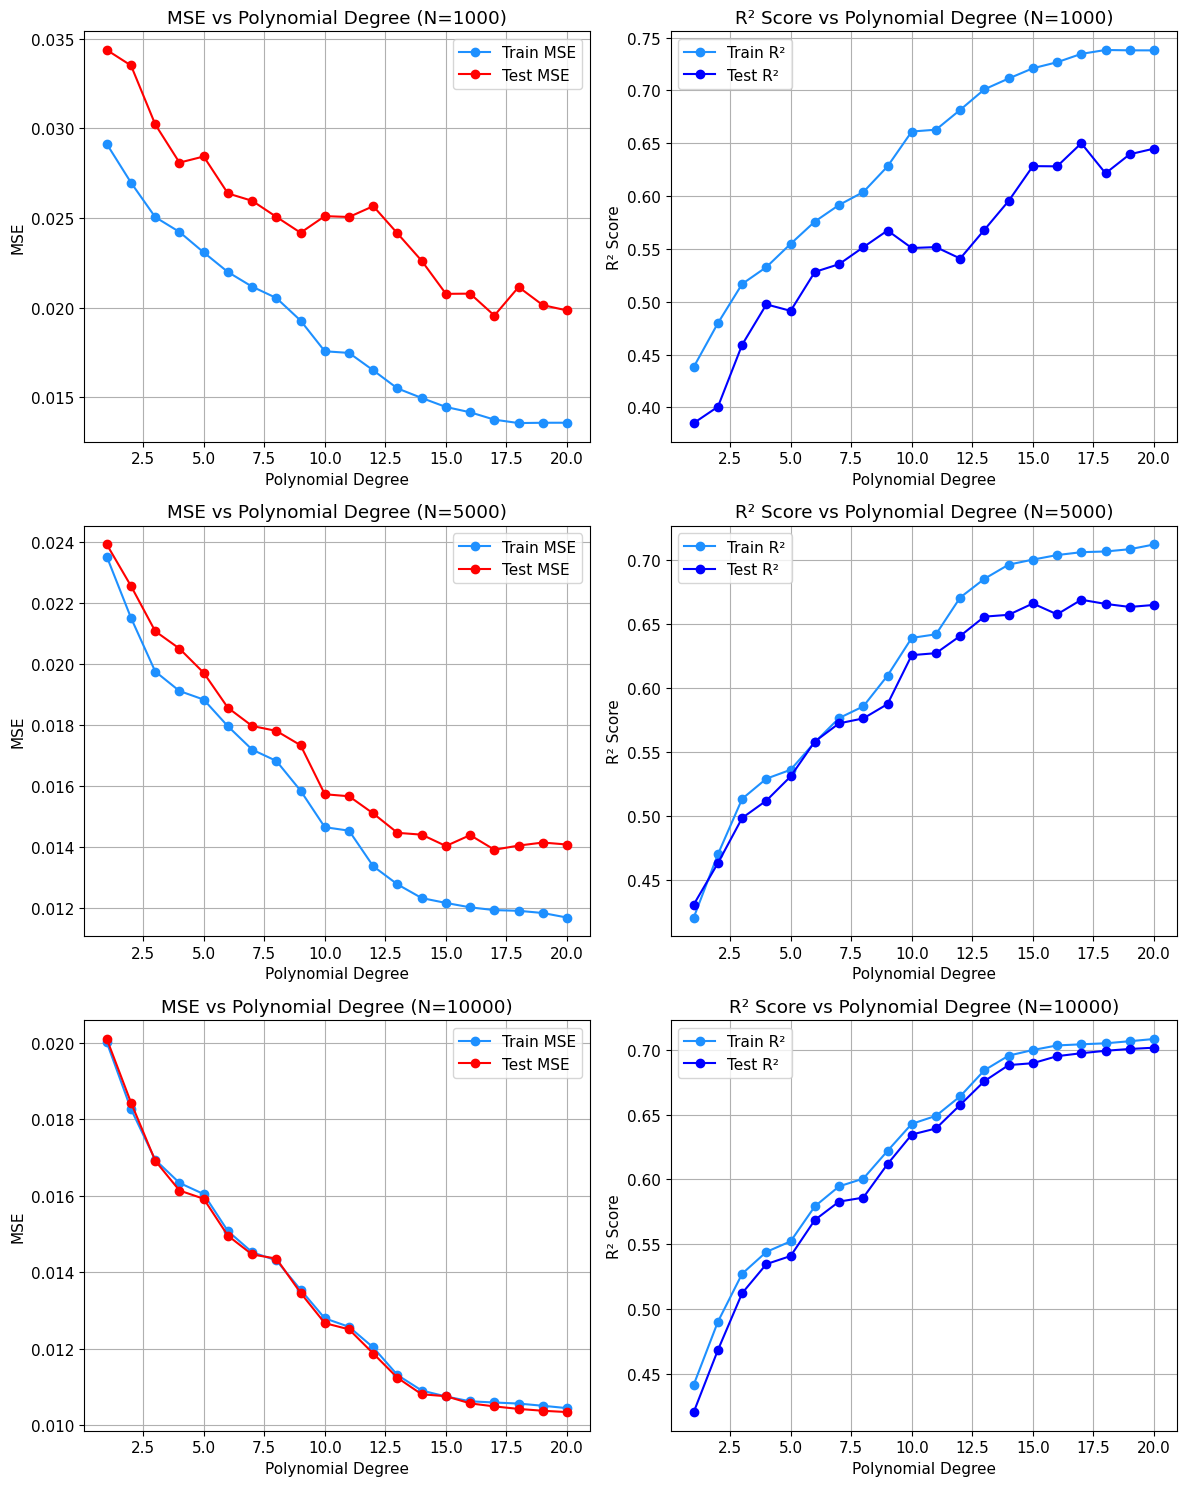

In [843]:
#testing for different points
num_points_list = [1000, 5000, 10000]

#function for min-max scaling
def min_max_scaling(x): 
    return (x - np.min(x)) / (np.max(x) - np.min(x))

#design matrix function
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  # elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)

    return X

plt.figure(figsize=(12, 15))

for idx, num_points in enumerate(num_points_list):
    points = np.column_stack((np.random.randint(0, terrain1.shape[0], size=num_points), np.random.randint(0, terrain1.shape[1], size=num_points)))

    #pick out z values from terrain data
    z = np.zeros([num_points, 1]) 
    for i in range(num_points):
        z[i] = terrain1[int(points[i, 0]), int(points[i, 1])]

    # Scale the z values and x, y coordinates
    z_scaled = min_max_scaling(z).flatten()
    x_scaled = min_max_scaling(points[:, 0])
    y_scaled = min_max_scaling(points[:, 1])

    # Using degree 20, creating design matrix
    degree = 20
    X = create_X(x_scaled, y_scaled, degree)

    # Split the data into training and testing sets
    X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Centering
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    MSE_train_values = []
    MSE_test_values = []
    R2_train_values = []
    R2_test_values = []

    # Loop through polynomial degrees
    for i in range(1, degree + 1):
        c = int((i + 2) * (i + 1) / 2)  # number of columns in our design matrix
        X_tilde_train = X_train_scaled[:, :c] 
        X_tilde_test = X_test_scaled[:, :c]
        
        # Calculate beta using the pseudo-inverse
        beta = np.linalg.pinv(X_tilde_train.T @ X_tilde_train) @ X_tilde_train.T @ z_train_scaled
        
        # Predicting training and testing outputs
        y_train_pred = X_tilde_train @ beta + z_train_mean
        y_test_pred = X_tilde_test @ beta + z_train_mean
        
        # Calculate MSE and R² values
        MSE_train_values.append(mean_squared_error(z_train, y_train_pred))
        MSE_test_values.append(mean_squared_error(z_test, y_test_pred))
        R2_train_values.append(r2_score(z_train, y_train_pred))
        R2_test_values.append(r2_score(z_test, y_test_pred))

    degrees = np.arange(1, degree + 1)

    # Plotting the results
    plt.subplot(3, 2, 1 + 2 * idx)
    plt.plot(degrees, MSE_train_values, marker='o', label='Train MSE', color='dodgerblue')
    plt.plot(degrees, MSE_test_values, marker='o', label='Test MSE', color='red')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Polynomial Degree (N={num_points})')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 2 + 2 * idx)
    plt.plot(degrees, R2_train_values, marker='o', label='Train R²', color='dodgerblue')
    plt.plot(degrees, R2_test_values, marker='o', label='Test R²', color='blue')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R² Score')
    plt.title(f'R² Score vs Polynomial Degree (N={num_points})')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

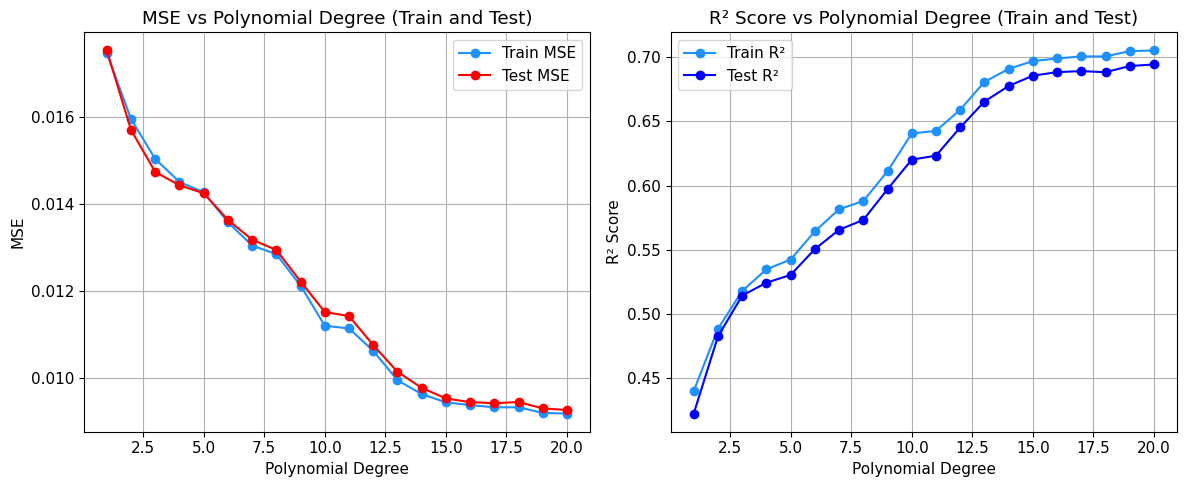

In [844]:
#sample 5000 points from the terrain
num_points = 5000
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size=num_points), np.random.randint(0, terrain1.shape[1], size=num_points)))

#pick out z values from terrain data
z = np.zeros([num_points, 1]) 
for i in range(num_points):
    z[i] = terrain1[int(points[i, 0]), int(points[i, 1])]

#min-max scaling function
def min_max_scaling(x): 
    return (x - np.min(x)) / (np.max(x) - np.min(x))

#scale the z values and x, y coordinates
z_scaled = min_max_scaling(z).flatten()
x_scaled = min_max_scaling(points[:, 0])
y_scaled = min_max_scaling(points[:, 1])

#design matrix
def create_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n + 1) * (n + 2) / 2)  #elements in beta
    X = np.ones((N, l))

    for i in range(1, n + 1):
        q = int((i) * (i + 1) / 2)
        for k in range(i + 1):
            X[:, q + k] = (x ** (i - k)) * (y ** k)

    return X

#using degree 20, creating design matrix
degree = 20
X = create_X(x_scaled, y_scaled, degree)

#split the data into training and testing sets
X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

#scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#centering
z_train_mean = np.mean(z_train)
z_train_scaled = z_train - z_train_mean
z_test_scaled = z_test - z_train_mean

MSE_train_values = []
MSE_test_values = []
R2_train_values = []
R2_test_values = []

for i in range(1, degree + 1):
    c = int((i + 2) * (i + 1) / 2) #number of columns in our design matrix
    X_tilde_train = X_train_scaled[:, :c] 
    X_tilde_test = X_test_scaled[:, :c]
    
    beta = np.linalg.pinv(X_tilde_train.T @ X_tilde_train) @ X_tilde_train.T @ z_train_scaled
    
    y_train_pred = X_tilde_train @ beta + z_train_mean
    y_test_pred = X_tilde_test @ beta + z_train_mean
    
    MSE_train_values.append(mean_squared_error(z_train, y_train_pred))
    MSE_test_values.append(mean_squared_error(z_test, y_test_pred))
    R2_train_values.append(r2_score(z_train, y_train_pred))
    R2_test_values.append(r2_score(z_test, y_test_pred))

degrees = np.arange(1, degree + 1)

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, MSE_train_values, marker='o', label='Train MSE', color='dodgerblue')
plt.plot(degrees, MSE_test_values, marker='o', label='Test MSE', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(degrees, R2_train_values, marker='o', label='Train R²', color='dodgerblue')
plt.plot(degrees, R2_test_values, marker='o', label='Test R²', color='blue')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree (Train and Test)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


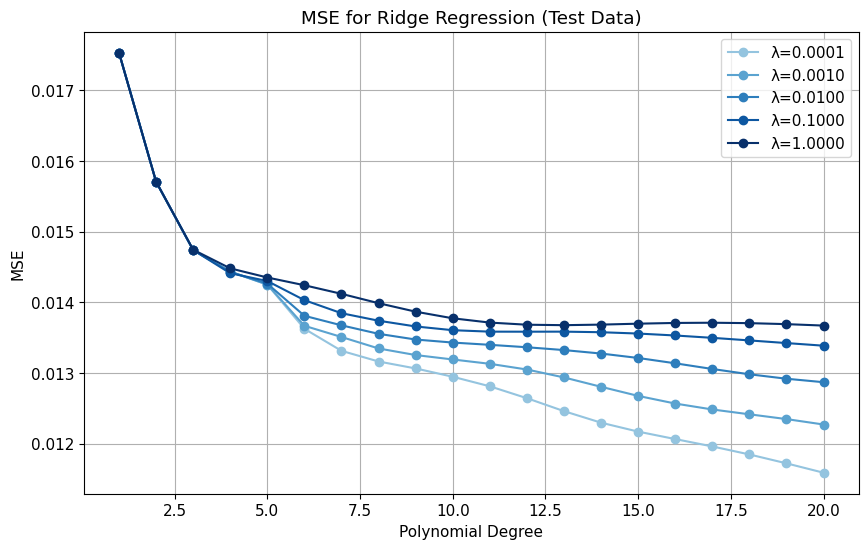

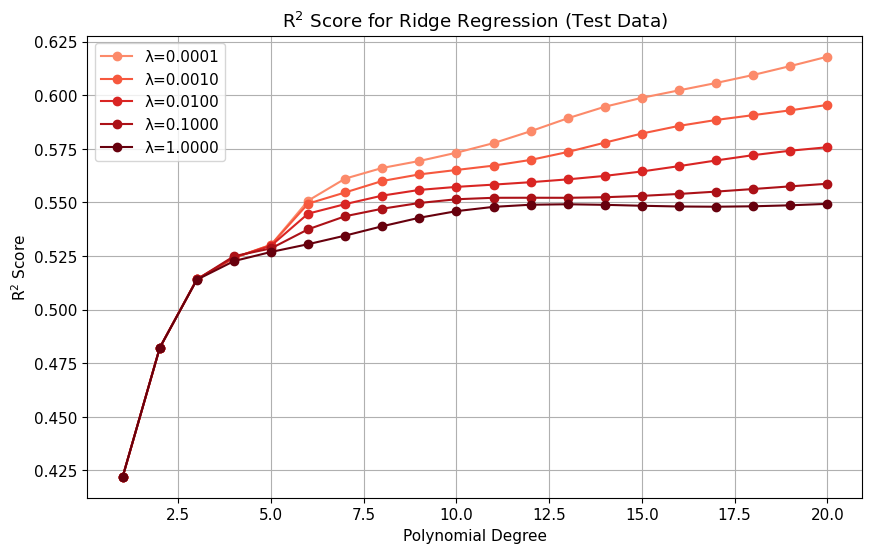

In [845]:
degrees = np.arange(1, degree +1) 
lambdas = np.logspace(-4, 0, 5) 

MSE_Ridge_train = np.zeros((len(degrees), len(lambdas)))
MSE_Ridge_test = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_train = np.zeros((len(degrees), len(lambdas)))
R2_Ridge_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x_scaled, y_scaled, n=deg)
    X = X[:, 1:] 

    #Train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

    #Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Center
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    #making identity matrix, p is number of columns in design matrix
    p = X_train_scaled.shape[1]
    I = np.eye(p)

    #ridge regression
    for j, lmb in enumerate(lambdas):
        Ridgebeta = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lmb * I) @ X_train_scaled.T @ z_train_scaled

        y_train_pred = X_train_scaled @ Ridgebeta + z_train_mean
        y_test_pred = X_test_scaled @ Ridgebeta + z_train_mean

        MSE_Ridge_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Ridge_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Ridge_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Ridge_test[i, j] = r2_score(z_test, y_test_pred)


mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Ridge_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Ridge Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.599e-02, tolerance: 2.495e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e-01, tolerance: 2.495e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

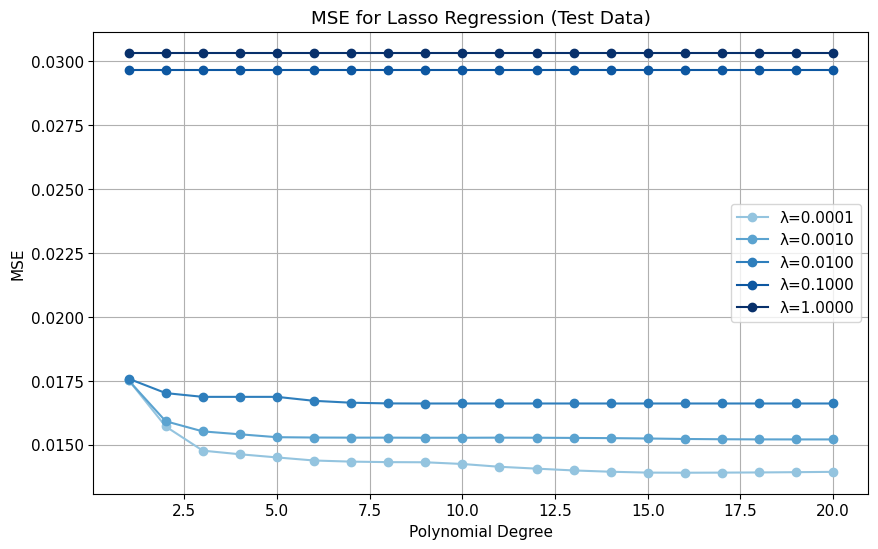

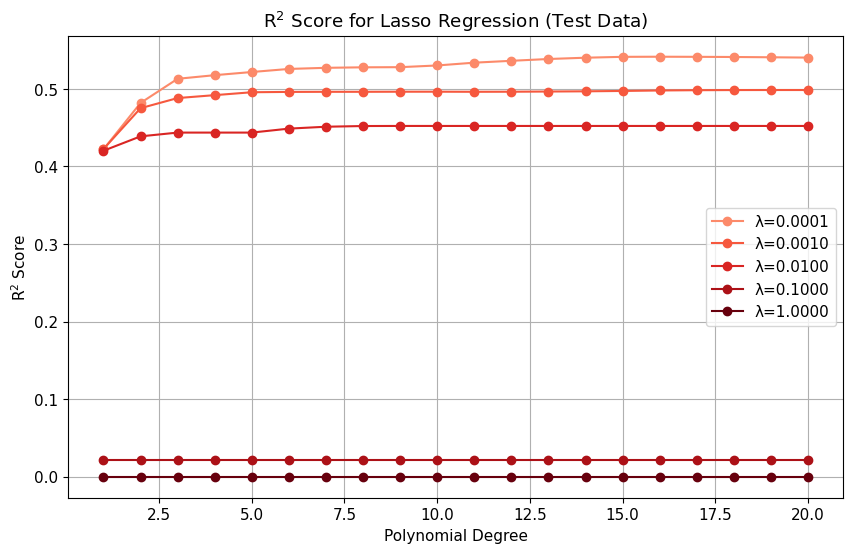

In [846]:
MSE_Lasso_train = np.zeros((len(degrees), len(lambdas)))
MSE_Lasso_test = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_train = np.zeros((len(degrees), len(lambdas)))
R2_Lasso_test = np.zeros((len(degrees), len(lambdas)))

for i, deg in enumerate(degrees):
    X = create_X(x_scaled, y_scaled, n=deg)
    X = X[:, 1:]  #remove the intercept

    X_train, X_test, z_train, z_test = train_test_split(X, z_scaled, test_size=0.2, random_state=1042)

    #scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #centering
    z_train_mean = np.mean(z_train)
    z_train_scaled = z_train - z_train_mean
    z_test_scaled = z_test - z_train_mean

    #lasso regression
    for j, lmb in enumerate(lambdas):
        lasso = Lasso(alpha=lmb, max_iter=10000)
        lasso.fit(X_train_scaled, z_train_scaled)

        y_train_pred = lasso.predict(X_train_scaled) + z_train_mean
        y_test_pred = lasso.predict(X_test_scaled) + z_train_mean

        MSE_Lasso_train[i, j] = mean_squared_error(z_train, y_train_pred)
        MSE_Lasso_test[i, j] = mean_squared_error(z_test, y_test_pred)
        R2_Lasso_train[i, j] = r2_score(z_train, y_train_pred)
        R2_Lasso_test[i, j] = r2_score(z_test, y_test_pred)

#plotting results
plt.rcParams.update({'font.size': 11})

mse_colors = plt.cm.Blues(np.linspace(0.4, 1, len(lambdas)))
plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, MSE_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=mse_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

r2_colors = plt.cm.Reds(np.linspace(0.4, 1, len(lambdas)))
plt.figure(figsize=(10, 6))
for j, lmb in enumerate(lambdas):
    plt.plot(degrees, R2_Lasso_test[:, j], marker='o', label=f'λ={lmb:.4f}', color=r2_colors[j])
plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$ Score for Lasso Regression (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

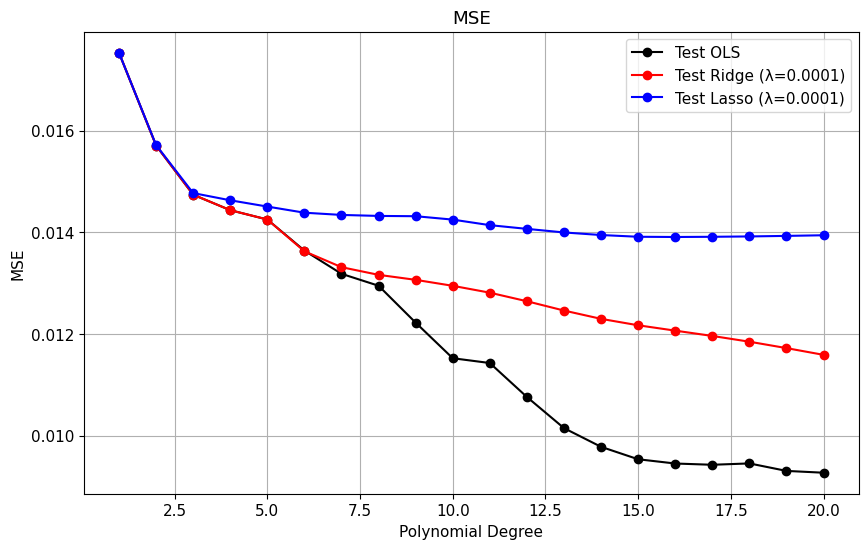

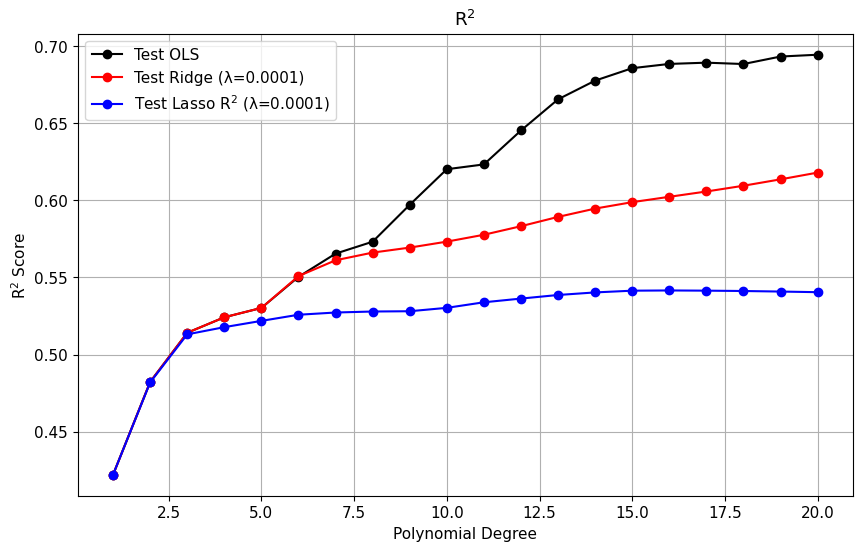

In [847]:
#using best lambda value, chosen from previous graphs
lambda_value = 0.0001

best_MSE_Ridge_test = MSE_Ridge_test[:, 0] 
best_MSE_Lasso_test = MSE_Lasso_test[:, 0]

best_R2_Ridge_test = R2_Ridge_test[:, 0]
best_R2_Lasso_test = R2_Lasso_test[:, 0]

plt.rcParams.update({'font.size': 11})

plt.figure(figsize=(10, 6))
plt.plot(degrees, MSE_test_values, marker='o', color='black', label='Test OLS')
plt.plot(degrees, best_MSE_Ridge_test, marker='o', label='Test Ridge (λ=0.0001)', color='red')
plt.plot(degrees, best_MSE_Lasso_test, marker='o', label='Test Lasso (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('MSE')
plt.legend()
plt.grid(True)
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(degrees, R2_test_values, marker='o', label='Test OLS', color='black')
plt.plot(degrees, best_R2_Ridge_test, marker='o', label='Test Ridge (λ=0.0001)', color='red')
plt.plot(degrees, best_R2_Lasso_test, marker='o', label='Test Lasso R$^2$ (λ=0.0001)', color='blue')

plt.xlabel('Polynomial Degree')
plt.ylabel('R$^2$ Score')
plt.title('R$^2$')
plt.legend()
plt.grid(True)
plt.show() 

Degree 1: Error = 0.0176, Bias^2 = 0.0176, Variance = 0.0000
Degree 2: Error = 0.0163, Bias^2 = 0.0162, Variance = 0.0000
Degree 3: Error = 0.0153, Bias^2 = 0.0153, Variance = 0.0000
Degree 4: Error = 0.0149, Bias^2 = 0.0149, Variance = 0.0000
Degree 5: Error = 0.0147, Bias^2 = 0.0147, Variance = 0.0000
Degree 6: Error = 0.0140, Bias^2 = 0.0139, Variance = 0.0000
Degree 7: Error = 0.0135, Bias^2 = 0.0135, Variance = 0.0000
Degree 8: Error = 0.0133, Bias^2 = 0.0133, Variance = 0.0001
Degree 9: Error = 0.0126, Bias^2 = 0.0125, Variance = 0.0001
Degree 10: Error = 0.0114, Bias^2 = 0.0113, Variance = 0.0001
Degree 11: Error = 0.0109, Bias^2 = 0.0108, Variance = 0.0001
Degree 12: Error = 0.0098, Bias^2 = 0.0097, Variance = 0.0001
Degree 13: Error = 0.0090, Bias^2 = 0.0089, Variance = 0.0001
Degree 14: Error = 0.0090, Bias^2 = 0.0088, Variance = 0.0001
Degree 15: Error = 0.0086, Bias^2 = 0.0085, Variance = 0.0001
Degree 16: Error = 0.0083, Bias^2 = 0.0081, Variance = 0.0002
Degree 17: Error 

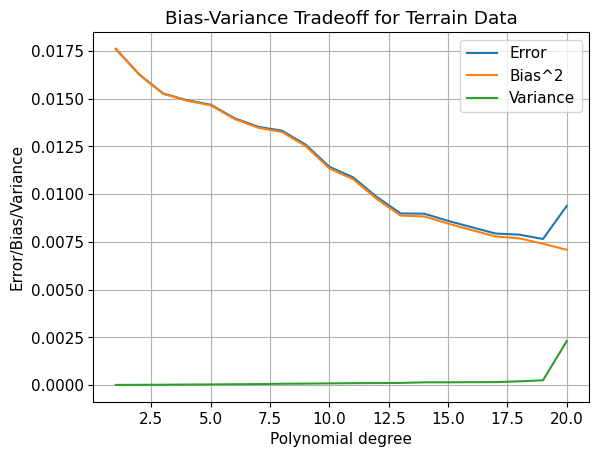

In [848]:
#split the data into training and testing sets
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_scaled, y_scaled, z_scaled, test_size=0.2)
z_test = z_test.reshape(-1, 1)

#number of bootstrap samples and maximum degree
n_bootstraps = 100
maxdegree = 20

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.arange(1, maxdegree + 1)

#linear regression for each poly degree
for degree in range(1, maxdegree + 1):
    model = LinearRegression(fit_intercept=False)
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    X_train_poly = create_X(x_train, y_train, degree)
    X_test_poly = create_X(x_test, y_test, degree)

    #bootstrap resampling
    for i in range(n_bootstraps):
        X_, z_ = resample(X_train_poly, z_train) 
        z_pred[:, i] = model.fit(X_, z_).predict(X_test_poly).ravel()

    #calc error, bias, and variance
    error[degree - 1] = np.mean(np.mean((z_test - z_pred) ** 2, axis=1))
    bias[degree - 1] = np.mean((z_test - np.mean(z_pred, axis=1, keepdims=True)) ** 2)
    variance[degree - 1] = np.mean(np.var(z_pred, axis=1))

    print(f'Degree {degree}: Error = {error[degree - 1]:.4f}, Bias^2 = {bias[degree - 1]:.4f}, Variance = {variance[degree - 1]:.4f}')

plt.rcParams.update({'font.size': 11})
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='Bias^2')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polynomial degree')
plt.ylabel('Error/Bias/Variance')
plt.legend()
plt.title('Bias-Variance Tradeoff for Terrain Data')
plt.grid(True)
plt.show()

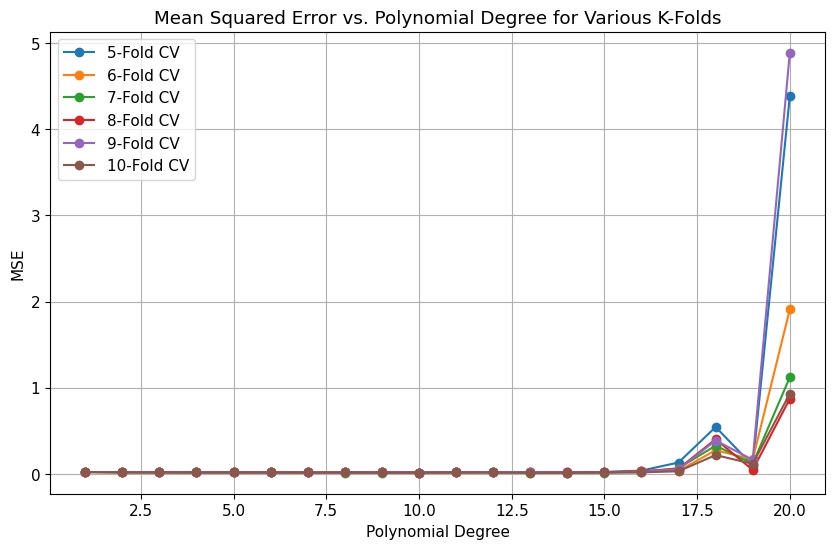

In [849]:
#choosing number of points 1000, to increase computational efficiency
num_points = 1000
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size=num_points), np.random.randint(0, terrain1.shape[1], size=num_points)))

z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i, 0]), int(points[i, 1])]

#scaling z values and x, y coordinates
z_scaled = min_max_scaling(z).flatten()
x_scaled = min_max_scaling(points[:, 0])
y_scaled = min_max_scaling(points[:, 1])

degree = 20
polynomial_degrees = np.arange(1, degree + 1)

plt.figure(figsize=(10, 6)) 

#looping over number of k-folds
for k in range(5, 11):
    #making an empty list to store MSE values
    estimated_mse = np.zeros(degree)
    
    #loop over degrees
    for polydegree in polynomial_degrees:
        X = create_X(x_scaled, y_scaled, polydegree) 
        OLS = LinearRegression(fit_intercept=False)
        
        kfold = KFold(n_splits=k, shuffle=True, random_state=1042) #initialize kfold instance
        mse_scores = cross_val_score(OLS, X, z_scaled, scoring='neg_mean_squared_error', cv=kfold) #perform cross validation to estimate MSE
        
        #store the negative MSE for every fold
        estimated_mse[polydegree - 1] = -np.mean(mse_scores) #average and negate MSE

    plt.plot(polynomial_degrees, estimated_mse, marker='o', label=f'{k}-Fold CV')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Mean Squared Error vs. Polynomial Degree for Various K-Folds')
plt.legend()
plt.grid(True)
plt.show()
